In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import norm

In [2]:
beta_0 = -4.0
results = {}
N = 1000

In [3]:
with open('MLR/results_mlr.pkl', 'rb') as pickle_file:
    results["MLR"] = pickle.load(pickle_file)

print(results["MLR"]["ate_estimates"].mean(axis=0))
print(results["MLR"]["se_estimates"].mean(axis=0))

[-4.8238148]
[0.34428532]


In [4]:
with open('KNN/opt_params_knn.pkl', 'rb') as pickle_file:
    opt_dict_knn = pickle.load(pickle_file)

print(opt_dict_knn)

{'treat': {'n_neighbors': 4, 'p': 3}, 'control': {'n_neighbors': 4, 'p': 3}}


In [5]:
with open('KNN/results_knn.pkl', 'rb') as pickle_file:
    results["KNN"] = pickle.load(pickle_file)

print(results["KNN"]["ate_estimates"].mean(axis=0))
print(results["KNN"]["se_estimates"].mean(axis=0))

[-4.14891866]
[0.16456598]


In [6]:
with open('Random_Forest/opt_params_rf.pkl', 'rb') as pickle_file:
    opt_dict_rf = pickle.load(pickle_file)

print(opt_dict_rf)

{'l': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 272}, 'm': {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 128}}


In [7]:
with open('Random_Forest/results_rf.pkl', 'rb') as pickle_file:
    results["Random Forest"] = pickle.load(pickle_file)

print(results["Random Forest"]["ate_estimates"].mean(axis=0))
print(results["Random Forest"]["se_estimates"].mean(axis=0))

[-4.09033493]
[0.18512973]


In [8]:
import pickle

with open('XGBoost/opt_params_xgb.pkl', 'rb') as pickle_file:
    opt_dict_xgb = pickle.load(pickle_file)

print(opt_dict_xgb)

{'l': {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 335, 'reg_lambda': 6, 'subsample': 0.8}, 'm': {'learning_rate': 0.06, 'max_depth': 2, 'n_estimators': 105, 'reg_lambda': 10, 'subsample': 0.8}}


In [9]:
with open('XGBoost/results_xgb.pkl', 'rb') as pickle_file:
    results["XGBoost"] = pickle.load(pickle_file)

print(results["XGBoost"]["ate_estimates"].mean(axis=0))
print(results["XGBoost"]["se_estimates"].mean(axis=0))

[-4.00455071]
[0.14272617]


In [10]:
colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:purple']
grid = np.linspace(-4, 4, 100)
pdf_values = norm.pdf(grid)

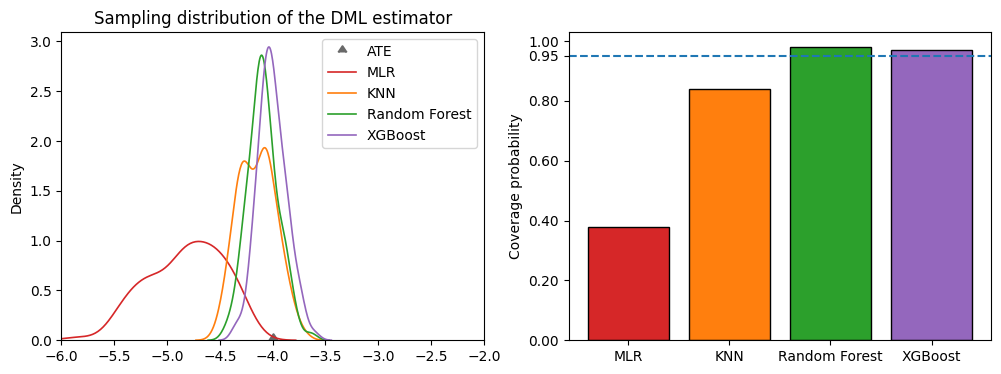

In [101]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

axes[0].scatter(beta_0, 0, marker=10, color='dimgrey', label='ATE')

for i, (ml_name, result) in enumerate(results.items()):
    sns.kdeplot(result['ate_estimates'].flatten(), ax=axes[0], linewidth=1.2, color=colors[i], label=ml_name)

axes[0].set_title('Sampling distribution of the DML estimator')
axes[0].set_xlim(left=-6, right=-2)

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='upper right')

axes[1].axhline(y=0.95, color='tab:blue', linestyle='--', label='Nominal')

for i, (ml_name, result) in enumerate(results.items()):
    CIs_list = result["CIs"]
    cov_prob = np.mean([(beta_0>=CIs[0]) & (beta_0<=CIs[1]) for CIs in CIs_list])
    axes[1].bar(ml_name, cov_prob, color=colors[i], edgecolor='black')

axes[1].set_yticks([0.0,0.2,0.4,0.6,0.8,0.95,1.0])
axes[1].set_ylabel('Coverage probability')

fig.savefig('Sampling_distribution.png', dpi=300, bbox_inches='tight')

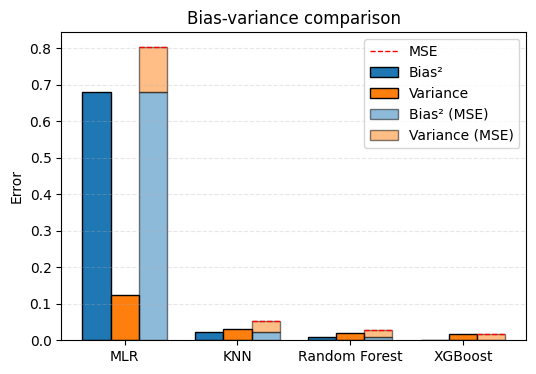

In [103]:
fig, ax = plt.subplots(figsize=(6, 4))

ml_names = list(results.keys())
bias_mc_squared = []
var_mc = []
mse_mc = []

for ml_name, result in results.items():
    J = np.mean(result['ate_estimates'])
    bias_mc_squared.append((J - beta_0) ** 2)
    var_mc.append(np.mean((result['ate_estimates']-J)**2))
    mse_mc.append(np.mean((result['ate_estimates']-beta_0)**2))
    J = np.mean(result['ate_estimates'])

x = np.arange(len(ml_names))
width = 0.25

bar1 = ax.bar(x - width/2, bias_mc_squared, width, label='Bias²', color='#1f77b4', edgecolor='black')
bar2 = ax.bar(x + width/2, var_mc, width, label='Variance', color='#ff7f0e', edgecolor='black')

bar_mse_bottom = ax.bar(x + width*1.5, bias_mc_squared, width, label='Bias² (MSE)', 
                        color='#1f77b4', alpha=0.5, edgecolor='black')
bar_mse_top = ax.bar(x + width*1.5, var_mc, width, bottom=bias_mc_squared, 
                     label='Variance (MSE)', color='#ff7f0e', alpha=0.5, edgecolor='black')

ax.hlines(mse_mc, x + width*1.5 - width/2, x + width*1.5 + width/2, 
          colors='red', linestyles='dashed', linewidth=1, label='MSE')

ax.set_xticks(x + width/2)
ax.set_xticklabels(ml_names)
ax.set_ylabel('Error')
ax.set_title('Bias-variance comparison')
ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.3)

fig.savefig('mse.png', dpi=300, bbox_inches='tight')